In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import scale, minmax_scale
from torch.utils.data import TensorDataset, DataLoader,Dataset

import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from sklearn.datasets import fetch_openml
X, y  = fetch_openml(data_id=40996, return_X_y=True, as_frame=False) 

In [5]:
# Sélection des targets avec pandas
A = pd.DataFrame(X)
A['y'] = y
B = A.loc[A.index[A['y']=='9'].union(A.index[A['y']=='5'])]

X_5_9 = torch.tensor(minmax_scale(B.drop("y", axis=1)).astype(np.float32)).reshape(B.shape[0],1,28,28)
y_5_9 = torch.tensor(B.y.replace(['5','9'],[0,1]).values.astype(np.float32)).unsqueeze(-1)
y_5_9

tensor([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [0.]])

In [6]:
# On fait en sorte de retourner le nom de l'article correspondant au label...

def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['sandal','ankle boot']
    return [text_labels[int(i)] for i in labels]



Ici On fait en sorte d'avoir un train , valid et un test set, et ceci en effecutuant deux fois un train_test_split.

In [7]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X_5_9, y_5_9, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.20, random_state=42)

Creation de nos loaders.

In [8]:
train_set = TensorDataset(X_train, y_train) # on lie les entrées aux targets attentues
val_set = TensorDataset(X_val, y_val) # on lie les entrées aux targets attentues
test_set = TensorDataset(X_test, y_test) # on lie les entrées aux targets attentues

train_loader = DataLoader(train_set,
                                          shuffle=True) # pour faciliter l'échantillonage en mini-batch
val_loader = DataLoader(val_set,
                                          shuffle=True) # pour faciliter l'échantillonage en mini-batch
test_loader = DataLoader(test_set,
                                          shuffle=True) # pour faciliter l'échantillonage en mini-batch

Un peu de viasualisation:

In [157]:
a = next(iter(train_set))
a[0].size()


torch.Size([1, 28, 28])

In [158]:
len(train_set)

8960

tensor([0.])

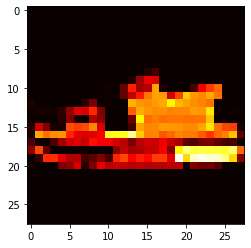

In [171]:
image, label = next(iter(train_set))
# We apply the squeeze() function to transform the input's shape to torch.Size([28, 28])
plt.imshow(image.squeeze(),cmap='hot')
label

Fonction prise du book du cours, elle fait en sorte d'affichier nos images

In [173]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy(),cmap='hot')
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


On passe à l'affichage, en faisant appel à la fonction show_images et aussi une autre fonction qui se charge de tranformer les labels (0,1) en leur vraie signification (sandal,ankle-boot)

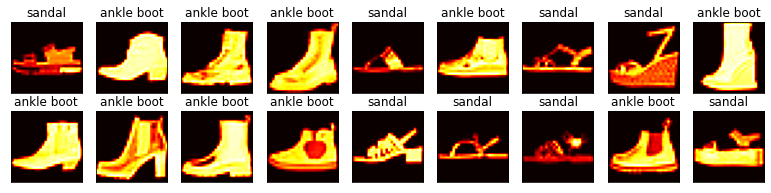

In [174]:
X, y = next(iter(torch.utils.data.DataLoader(train_set, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

## On cree une classe qui correspond a notre CNN...


In [9]:
#On cree une classe qui corrspend a notre CNN
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        
        self.fc1 = nn.Linear(in_features=32*5*5, out_features=150)
        self.fc2 = nn.Linear(in_features=150, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = torch.sigmoid(self.fc3(out))
        
        return out

In [10]:
model = Net()
model.to(device)

error = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


Une fonction de test qui nous servira à tester notre model apres chaque epoch

In [14]:
def test():

    with torch.no_grad():
        total = 0
        correct = 0
        labels_list = []
        for images, labels in test_loader:
            images, labels  = images.to(device), labels.to(device)
            labels_list.append(labels)

            test = images
            outputs = model(test)

            correct += torch.isclose(outputs,labels,atol=1e-01).sum().item()

            total += len(labels)

        accuracy = correct * 100 / total
        print('test_accuracy :',accuracy)

Phase d'entrainement, Validation et de test

In [15]:
num_epochs = 5
for epoch in range(num_epochs):

    running_loss = 0.0
    running_val_loss = 0.0

    for i, (images, labels) in enumerate(train_loader, 0):

        inputs, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:   
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    for j, val_test in enumerate(val_loader, 0):
        inputs_, labels_ = val_test[0].to(device), val_test[1].to(device)

        outputs_ = model(inputs_)
        val_loss = error(outputs_, labels_)


        # print statistics
        running_val_loss += val_loss.item()
        if j % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] val_loss: %.3f' %
                (epoch + 1, j + 1, running_val_loss / 2000))
            running_val_loss = 0.0
    test()    
      

[1,  2000] loss: 0.142
[1,  4000] loss: 0.132
[1,  6000] loss: 0.116
[1,  8000] loss: 0.111
[1,  2000] val_loss: 0.098
test_accuracy : 88.35714285714286
[2,  2000] loss: 0.099
[2,  4000] loss: 0.108
[2,  6000] loss: 0.095
[2,  8000] loss: 0.091
[2,  2000] val_loss: 0.081
test_accuracy : 89.89285714285714
[3,  2000] loss: 0.088
[3,  4000] loss: 0.081
[3,  6000] loss: 0.074
[3,  8000] loss: 0.085
[3,  2000] val_loss: 0.090
test_accuracy : 88.35714285714286
[4,  2000] loss: 0.076
[4,  4000] loss: 0.065
[4,  6000] loss: 0.059
[4,  8000] loss: 0.069
[4,  2000] val_loss: 0.056
test_accuracy : 93.25
[5,  2000] loss: 0.061
[5,  4000] loss: 0.053
[5,  6000] loss: 0.051
[5,  8000] loss: 0.060
[5,  2000] val_loss: 0.051
test_accuracy : 94.17857142857143


Remarque :
--------
On peut augmonter la complexité de notre Net, l'accuracy augmonte, mais le cout également. Ce qui nous mene à penser qu'à partir d'une certaine accuracy assez satisfaisante il est inutile de complexifier notre model encore plus, cela ne vaut pas le cout.